Install appropriate packages and load in datasets from NHANES (https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?Cycle=2021-2023)

In [502]:
# !pip install (any package that is not installed)

In [503]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")


In [504]:
# Constants that can be changed
MISSINGNESS_THRESHOLD = 20
IMPUTATION_STRATEGY = 'mean'
KNN_NEIGHBORS = 5
BINARY_THRESHOLD = 10

DPQ_L.xpt is the dataset containg depression questions (PHQ-9 Assessment) - this will be used to determine the depression status of the participants.


In [505]:
depression_df = pd.read_sas('datasets/questionaire_data/DPQ_L.xpt', format='xport', encoding='latin1')


In [506]:
display(depression_df)

,SEQN,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
0,130378.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,130379.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
2,130380.0,5.397605e-79,5.397605e-79,1.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
3,130386.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
4,130387.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6332,142305.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6333,142307.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,NaN
6334,142308.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,NaN
6335,142309.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,NaN


The breakdown of PHQ-9 scores for our dataset

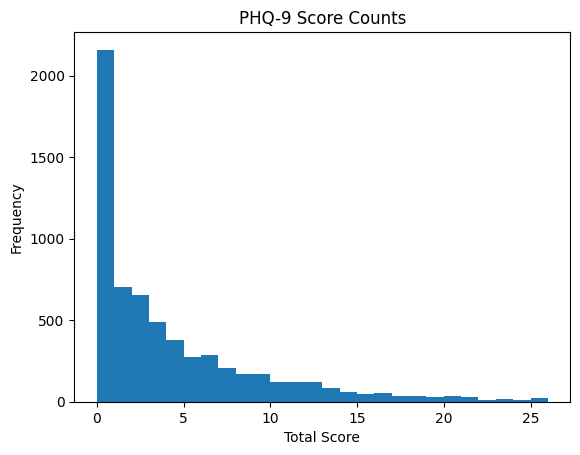

In [507]:
# counts of total sums across all questions of last 10 columns only add if value is 1, 2, 3
depression_df["DPQSUM"] = depression_df.iloc[:, -10:].apply(lambda x: x[x.isin([1, 2, 3])].sum(), axis=1)

# histogram of the sums
plt.hist(depression_df["DPQSUM"], bins=range(0, 27, 1))
plt.title("PHQ-9 Score Counts")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

Loading in the other data sets for prediction and casual understanding of depression scores. Datasets come from the demographic, dietary, examination, and questionnaire subsets of the NHANES dataset. 

In [508]:
base_dir = "datasets"
dataframes = {}

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".xpt"):
            file_path = os.path.join(root, file)
            dataset_name = os.path.splitext(file)[0]
            new_df = pd.read_sas(file_path, format='xport', encoding='latin1')
            dataframes[dataset_name] = new_df

Creating one large dataframe based on the overlapping SEQN values in each dataset (each participant has a unique SEQN value). This step also removes any columns that have a missingness percentage greater than the constant **MISSINGNESS_THRESHOLD**.

In [509]:
filtered_dataframes = []

for name, df in dataframes.items():
    missingness = df.isnull().mean() * 100
    low_missingness_cols = missingness[missingness <= MISSINGNESS_THRESHOLD].index
    filtered_df = df[low_missingness_cols]
    filtered_dataframes.append(filtered_df)

# Find common SEQNs across all DataFrames
common_seqn = set(filtered_dataframes[0]["SEQN"])
for df in filtered_dataframes[1:]:
    common_seqn = common_seqn.intersection(df["SEQN"])

# Filter DataFrames to include only rows with common SEQNs
filtered_dataframes = [df[df["SEQN"].isin(common_seqn)] for df in filtered_dataframes]

merged_df = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='inner'), filtered_dataframes)
merged_df = pd.merge(merged_df, depression_df[["SEQN", "DPQSUM"]], on="SEQN", how="inner")

# drop SEQN column
merged_df = merged_df.drop(columns=["SEQN"])

display(merged_df)

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DMDBORN4,DMDHHSIZ,WTINT2YR,WTMEC2YR,...,SMQ846,SMQ851,SMDANY,SMQ020,SMAQUEX2,WHD010,WHD020,WHD050,WHQ070,DPQSUM
0,12.0,2.0,1.0,43.0,5.0,6.0,2.0,4.0,50055.450807,54374.463898,...,NaN,NaN,NaN,1.0,1.0,71.0,190.0,200.0,1.0,0.0
1,12.0,2.0,1.0,66.0,3.0,3.0,1.0,2.0,29087.450605,34084.721548,...,2.0,2.0,2.0,1.0,1.0,70.0,220.0,220.0,2.0,1.0
2,12.0,2.0,2.0,44.0,2.0,2.0,2.0,7.0,80062.674301,81196.277992,...,2.0,2.0,2.0,2.0,1.0,60.0,150.0,165.0,1.0,2.0
3,12.0,2.0,1.0,34.0,1.0,1.0,1.0,3.0,30995.282610,39988.452940,...,2.0,2.0,2.0,1.0,1.0,68.0,200.0,180.0,2.0,1.0
4,12.0,2.0,2.0,68.0,3.0,3.0,1.0,1.0,19896.970559,20776.254850,...,2.0,2.0,2.0,2.0,1.0,67.0,215.0,215.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4766,12.0,2.0,2.0,46.0,1.0,1.0,2.0,5.0,28399.611503,30517.128836,...,2.0,2.0,2.0,1.0,1.0,62.0,169.0,172.0,1.0,3.0
4767,12.0,2.0,2.0,69.0,5.0,7.0,1.0,2.0,33250.569425,47087.576098,...,2.0,2.0,2.0,1.0,1.0,63.0,165.0,160.0,1.0,0.0
4768,12.0,2.0,2.0,49.0,4.0,4.0,1.0,5.0,69419.620456,64962.328962,...,1.0,2.0,1.0,1.0,1.0,61.0,206.0,235.0,1.0,0.0
4769,12.0,2.0,1.0,50.0,2.0,2.0,2.0,3.0,32696.313477,44367.534132,...,2.0,2.0,2.0,2.0,1.0,69.0,174.0,180.0,1.0,0.0


Deal with non-numeric columns (commented out certain lines because those columns have too much missingness and have already been removed)

In [510]:
# Fix physical activity columns to be standardized
unit_conversion = {'D': 365, 'W': 52.14, 'M': 12, 'Y': 1}

def standardize_frequency(row, freq_col, unit_col):
    if pd.isna(row[unit_col]) or pd.isna(row[freq_col]):
        return None  
    return row[freq_col] * unit_conversion.get(row[unit_col], 1)

merged_df['PAD790_annualized'] = merged_df.apply(
    lambda row: standardize_frequency(row, 'PAD790Q', 'PAD790U'), axis=1)

merged_df['PAD810_annualized'] = merged_df.apply(
    lambda row: standardize_frequency(row, 'PAD810Q', 'PAD810U'), axis=1)

# merged_df['PAD790_total_minutes'] = merged_df['PAD790_annualized'] * merged_df['PAD800']
# merged_df['PAD810_total_minutes'] = merged_df['PAD810_annualized'] * merged_df['PAD820']

# merged_df = merged_df.drop(columns=['PAD800', 'PAD820'])
merged_df = merged_df.drop(columns=['PAD790Q', 'PAD790U', 'PAD810Q', 'PAD810U'])

Deal with more non-numeric columns (columns related to the sleeping questionaire - each value is a time that needs to become a number)

In [511]:
for col in ['SLQ300', 'SLQ310', 'SLQ320', 'SLQ330']:
    merged_df[col] = pd.to_numeric(merged_df[col].str.replace(r'\D', ''), errors='coerce')

Impute based on chosen strategy (Tried median, mean, most_frequent, and KNN)

In [512]:
if IMPUTATION_STRATEGY == 'KNN':
    imputer = KNNImputer(n_neighbors=KNN_NEIGHBORS)
else:
    imputer = SimpleImputer(strategy=f'{IMPUTATION_STRATEGY}')

merged_df = pd.DataFrame(imputer.fit_transform(merged_df), columns=merged_df.columns)

Drop all PHQ-9 related columns except for the total score

In [513]:
merged_df = merged_df.drop(columns=merged_df.columns[merged_df.columns.str.startswith("DPQ") & ~merged_df.columns.str.startswith("DPQSUM")])

# dpqsum at end
merged_df = merged_df[[c for c in merged_df if c != 'DPQSUM'] + ['DPQSUM']]

Split up target (dpqsum) two different ways: binary (depressed or not) and continuous (minimal, mild, moderate, moderately severe, severe)

Binary: 0-9 not depressed, 10-27 depressed

Continuous: 0-4 minimal, 5-9 mild, 10-14 moderate, 15-19 moderately severe, 20-27 severe


In [514]:
merged_df["DEPRESSED"] = merged_df["DPQSUM"].apply(lambda x: 1 if x >= BINARY_THRESHOLD else 0)
merged_df["DEPRESSION_LEVEL"] = merged_df["DPQSUM"].apply(lambda x: 1 if x < 5 else 2 if x < 10 else 3 if x < 15 else 4 if x < 20 else 5)

# distribution of these targets
print("Binary Target Distribution:")
print(merged_df["DEPRESSED"].value_counts())
print("Continuous Target Distribution:")
print(merged_df["DEPRESSION_LEVEL"].value_counts())

Binary Target Distribution:
DEPRESSED
0    4099
1     672
Name: count, dtype: int64
Continuous Target Distribution:
DEPRESSION_LEVEL
1    3235
2     864
3     411
4     159
5     102
Name: count, dtype: int64


Far more rows are not depressed than depressed, so we need to randomly remove the non-depressed rows to balance the dataset. We do not want a biased classifier that always predicts a person to be not depressed.

In [515]:
not_depressed = merged_df[merged_df['DEPRESSED'] == 0]
depressed = merged_df[merged_df['DEPRESSED'] == 1]

# randomly remove some not depressed samples to balance the dataset
not_depressed_downsampled = resample(not_depressed, replace=False, n_samples=len(depressed), random_state=42)

balanced_df = pd.concat([not_depressed_downsampled, depressed])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# remove dpqsum column
balanced_df = balanced_df.drop(columns="DPQSUM")

print("New Binary Target Distribution:")
print(balanced_df['DEPRESSED'].value_counts())

New Binary Target Distribution:
DEPRESSED
0    672
1    672
Name: count, dtype: int64


We now have a balanced dataset. Can now split into training and testing sets.

In [516]:
X = balanced_df.drop(columns=["DEPRESSED", "DEPRESSION_LEVEL"])
y_binary = balanced_df["DEPRESSED"]
y_continuous = balanced_df["DEPRESSION_LEVEL"]
X_train, X_test, y_binary_train, y_binary_test, y_continuous_train, y_continuous_test = train_test_split(X, y_binary, y_continuous, test_size=0.2, random_state=42)

Try Random Forest model - looking at precision, recall, and f1-score to ensure no bias in the model.

In [517]:
results = {}
randomForest = RandomForestClassifier(random_state=42, max_depth=3, n_estimators=100)
randomForest.fit(X_train, y_binary_train)

y_binary_pred = randomForest.predict(X_test)
print("Binary Target Accuracy:", accuracy_score(y_binary_test, y_binary_pred))
print("Binary Target Classification Report:")
print(classification_report(y_binary_test, y_binary_pred))

Binary Target Accuracy: 0.7657992565055762
Binary Target Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       144
           1       0.74      0.77      0.75       125

    accuracy                           0.77       269
   macro avg       0.76      0.77      0.77       269
weighted avg       0.77      0.77      0.77       269



Now we will run cross-validaiton with 5 folds and get the average accuracy score

In [518]:
scores = cross_val_score(randomForest, X, y_binary, cv=5)
print("Random Forest Mean Score:", scores.mean())
results["Random Forest"] = scores.mean()

Random Forest Mean Score: 0.7366060034400489


Try Logistic Regression Model

In [519]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lr_scores = cross_val_score(lr_model, X_scaled, y_binary, cv=5)
print("Logistic Regression Mean Score:", lr_scores.mean())
results["Logistic Regression"] = lr_scores.mean()

Logistic Regression Mean Score: 0.7157548687787827


Try SVM Model

In [520]:
svm = SVC(kernel='rbf', random_state=42)
cv_scores = cross_val_score(svm, X_scaled, y_binary, cv=5)
print("SVM Mean Score:", cv_scores.mean())
results["SVM"] = cv_scores.mean()

SVM Mean Score: 0.7135438051378793


Try XGBoost Model

In [521]:
xgboost_model = XGBClassifier()
scores = cross_val_score(xgboost_model, X.to_numpy(), y_binary, cv=5, error_score='raise')
print("XGBoost Mean Score:", scores.mean())
results["XGBoost"] = scores.mean()

XGBoost Mean Score: 0.7433307440492704


Try LGBM Model

In [522]:
lgbm = LGBMClassifier(random_state=42, verbose=-1)
cv_scores = cross_val_score(lgbm, X, y_binary, cv=5)
print("LightGBM Mean Score:", cv_scores.mean())
results["LightGBM"] = cv_scores.mean()

LightGBM Mean Score: 0.7403290240248571


Try Stacking Classifier model (Logistic Regression on top of Random Forest, XGBoost, LGBM)

In [523]:
meta_model = LogisticRegression(max_iter=10000, random_state=42)

stacked_model = StackingClassifier(
    estimators=[
        ('rf', randomForest),
        # ('lr', lr_model),
        ('xgb', xgboost_model),
        ('lgbm', lgbm),
        # ('svm', svm)
    ],
    final_estimator=meta_model,
    cv=5
)

stacked_scores = cross_val_score(stacked_model, X, y_binary, cv=5)
print("Stacked Model Mean Score:", stacked_scores.mean())
results["Stacked Model"] = stacked_scores.mean()

Stacked Model Mean Score: 0.7440520446096655


Display cross-validation averages for each model

In [524]:
for model, score in results.items():
    print(f"{model} Mean Score: {score}")

Random Forest Mean Score: 0.7366060034400489
Logistic Regression Mean Score: 0.7157548687787827
SVM Mean Score: 0.7135438051378793
XGBoost Mean Score: 0.7433307440492704
LightGBM Mean Score: 0.7403290240248571
Stacked Model Mean Score: 0.7440520446096655


Stacking Classifier had the highest accuracy score with around 0.75. Not incredible for a binary classification task, but this was the best we could do given our data considering we tried different models, imputation strategies, and missingness thresholds.

Consider feature importance

In [525]:
# used for displaying the graphs with descriptive names
feature_name_mapping = {
    'HUQ010': 'General Health Condition',
    'HUQ090': 'Seen mental health professional/past yr',
    'BAQ321B': 'Past 12 months, prblms w/blurring vision',
    'BAQ321C': 'Past 12 months, problems with balance',
    'INDFMPIR': 'Family Poverty Income Ratio',
    'BAQ530': 'Past 5 years, how many times fallen?',
    'INDFMMPC': 'Family Monthly Poverty Level',
    'SMDANY': 'Used any tobacco product last 5 days',
    'OHQ620': 'How Often Aching in Mouth',
    'BAQ321D': 'Past 12 months, problems w/light-headed',
    'OHQ845': 'Health of Teeth and Gums',
    'SLD012': 'Sleep hours - weekdays or workdays',
    'SLQ310': 'Usual wake time on weekdays or workdays',
    'SLQ330': 'Usual wake time on weekends',
    'INQ300': 'Family has savings more than $20,000',
    'SMQ681': 'Smoked tobacco last 5 days',
    'SMQ851': 'Used smokeless tobacco last 5 days',
    'BAQ321A': 'Past 12 months, problems with vertigo',
    'PAD790_annualized': 'Annualized Moderate Physical Activity',
    'RIDAGEYR': 'Age in Years',
    'HOD051': 'Number of rooms in home',
    'DMDHHSIZ': 'Total number of people in the household',
    'BMXARML': 'Upper Arm Length (cm)',
    'BMXBMI': 'Body Mass Index (kg/m^2)',
    'SMQ846': 'Used last 5 days - E-cigarettes',
    }

Plotting the 20 most significant features given by the random forest model.

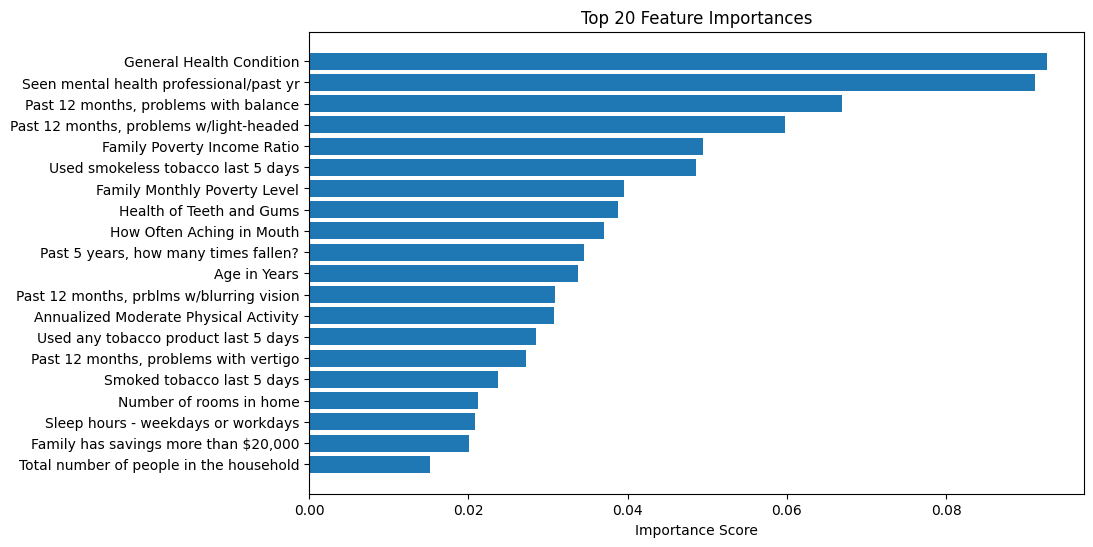

In [526]:
importances = randomForest.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

importance_df['Feature'] = importance_df['Feature'].map(feature_name_mapping)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.title('Top 20 Feature Importances')
plt.show()

The 10 most important features using the permutation importance method.

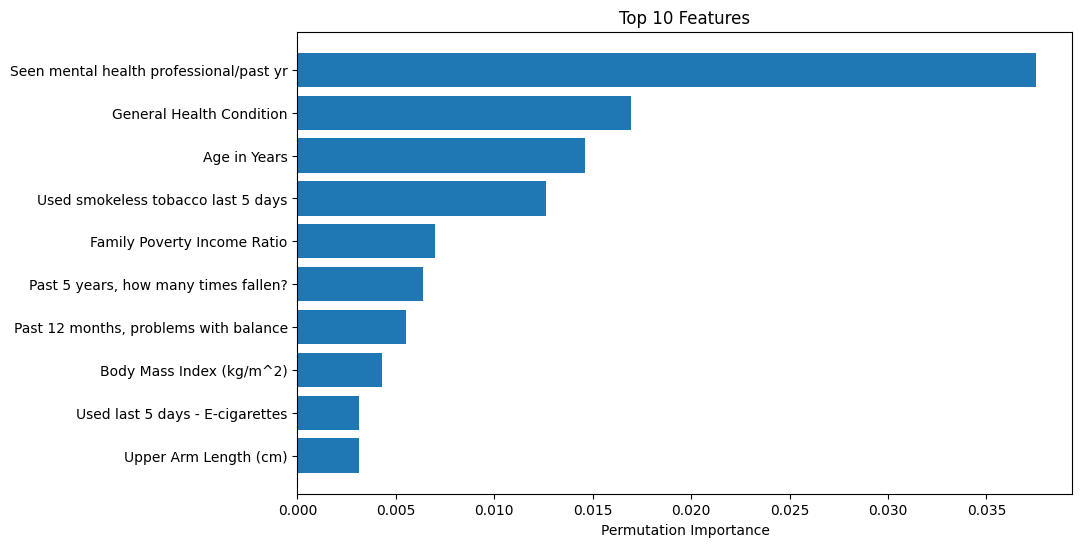

In [527]:
perm_importance = permutation_importance(randomForest, X, y_binary, scoring='accuracy', random_state=42)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False).head(10)

importance_df['Feature'] = importance_df['Feature'].map(feature_name_mapping)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Permutation Importance')
plt.title('Top 10 Features')
plt.show()

The significant features in these graphs largely align with what we would expect to be important in predicting depression (seen mental health professional, age, poverty, tobacco, BMI, etc.).